In [1]:
import numpy as np
import os, os.path
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

imgs = []
path_schere_train = "/home/florian/ml/SchereSteinPapier/train/Schere"
path_papier_train = "/home/florian/ml/SchereSteinPapier/train/Papier"
path_stein_train = "/home/florian/ml/SchereSteinPapier/train/Stein"

path_schere_test = "/home/florian/ml/SchereSteinPapier/test/Schere"
path_papier_test = "/home/florian/ml/SchereSteinPapier/test/Papier"
path_stein_test = "/home/florian/ml/SchereSteinPapier/test/Stein"

def import_images(path,label):
    imgs = []
    labels = []
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        imgs.append(np.array(Image.open(os.path.join(path,f))))
        labels.append(label)
    return(imgs,labels)

In [2]:
#import images and labels 
imgs_schere, labels_schere = import_images(path_schere_train, 'schere')
imgs_papier, labels_papier = import_images(path_papier_train, 'papier')
imgs_stein, labels_stein = import_images(path_stein_train, 'stein')

imgs = np.concatenate((imgs_schere, imgs_papier, imgs_stein))
labels = np.concatenate((labels_schere, labels_papier, labels_stein))

#one hot encoding of labels
labels = np.asarray(labels)
labels = labels.reshape(-1,1)
onehot = OneHotEncoder(sparse=False)
labels = onehot.fit_transform(labels)

In [3]:
# Import the `transform` module from `skimage`
from skimage import transform 

# Rescale the images in the `images` array
imgs = [transform.resize(image, (40, 40)) for image in imgs]
imgs = np.array(imgs)

/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
imgs_schere, labels_schere = import_images(path_schere_test, 'schere')
imgs_papier, labels_papier = import_images(path_papier_test, 'papier')
imgs_stein, labels_stein = import_images(path_stein_test, 'stein')

imgs_test = np.concatenate((imgs_schere, imgs_papier, imgs_stein))
labels_test = np.concatenate((labels_schere, labels_papier, labels_stein))

labels_test = np.asarray(labels_test)
labels_test = labels_test.reshape(-1,1)
labels_test = onehot.transform(labels_test)

imgs_test = [transform.resize(image, (40, 40)) for image in imgs_test]
imgs_test = np.array(imgs_test)

/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/florian/ml/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(636, 40, 40, 3)


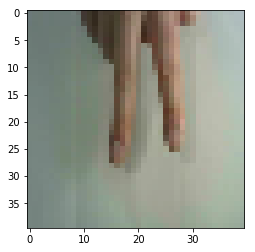

[0. 1. 0.]


In [5]:
print(np.shape(imgs))
plt.imshow(imgs[40])
plt.show()
print(labels[40])

In [6]:
imgs = rgb2gray(imgs)
imgs_test = rgb2gray(imgs_test)

(40, 40)
(3,)


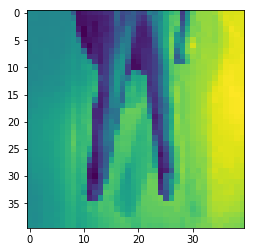

[0. 1. 0.]


In [7]:
print(np.shape(imgs[1]))
print(np.shape(labels[1]))
plt.imshow(imgs[45])
plt.show()
print(labels[45])

In [8]:
def CNN(inputs):
    #Input layer 
    input_layer = tf.reshape(inputs, [-1,40,40,1]) #=>[batch_size, 120,160,1]
    print(input_layer)
    
    #Conv layer 1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3,3],
        padding='same',
        activation=tf.nn.relu) #=>[batch_size, 120,160,32]
    print(conv1)
    #Pool layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2) #=>[batch_size, 60,80,32]
    print(pool1)
    #Conv layer 2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5,5],
        padding='same',
        activation=tf.nn.relu) #=>[batch_size, 60,80,64]
    print(conv2)
    #Pool layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2) #=>[batch_size,30,40,64] 
    print(pool2)
    #Reshape
    pool2_flat = tf.reshape(pool2, [-1, 10*10*64]) #=>[batch_size, 19200]
    print(pool2_flat)
    
    #Dense layer
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    print(dense)
    #Logit layer
    logits = tf.layers.dense(inputs=dense, units=3)
    print(logits)
    return(logits)
    
print('CNN ready')

CNN ready


In [9]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 40,40])
y = tf.placeholder(tf.float32, [None, 3])

# Parameters
learning_rate   = 0.002
training_epochs = 10
batch_size      = 40
display_step    = 1


_pred = CNN(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels= y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
_corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
init = tf.initialize_all_variables()

# Saver 
save_step = 1;
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Tensor("Reshape:0", shape=(?, 40, 40, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(?, 40, 40, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(?, 20, 20, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 10, 10, 64), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 6400), dtype=float32)
Tensor("dense/Relu:0", shape=(?, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(?, 3), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Network Ready to Go!


In [10]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [11]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(4575/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = next_batch(batch_size, imgs, labels)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: imgs_test, y: labels_test})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

Epoch: 000/010 cost: 0.788263356
 Training accuracy: 0.925
 Test accuracy: 0.830
Epoch: 001/010 cost: 0.079611180
 Training accuracy: 1.000
 Test accuracy: 0.930
Epoch: 002/010 cost: 0.023165305
 Training accuracy: 0.975
 Test accuracy: 0.960
Epoch: 003/010 cost: 0.005482983
 Training accuracy: 1.000
 Test accuracy: 0.980
Epoch: 004/010 cost: 0.001477758
 Training accuracy: 1.000
 Test accuracy: 0.960
Epoch: 005/010 cost: 0.000809806
 Training accuracy: 1.000
 Test accuracy: 0.970
Epoch: 006/010 cost: 0.000469786
 Training accuracy: 1.000
 Test accuracy: 0.970
Epoch: 007/010 cost: 0.000315134
 Training accuracy: 1.000
 Test accuracy: 0.950
Epoch: 008/010 cost: 0.000216908
 Training accuracy: 1.000
 Test accuracy: 0.960
Epoch: 009/010 cost: 0.000186787
 Training accuracy: 1.000
 Test accuracy: 0.950
Optimization Finished.


In [12]:
sess.close()